In [1]:
import numpy as np
import math
import csv
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from skbio.stats.composition import clr
from scipy.spatial.distance import dice
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

sns.set_style("ticks")
sns.palplot(sns.color_palette("colorblind", 10))

%matplotlib inline

In [2]:
COLORS = sns.color_palette("colorblind", 5)
TAXONOMIC_PROFILER = 'burst'
CLR = False
# CLASSIFIER = lambda: OneVsRestClassifier(RandomForestClassifier(n_estimators=12))
CLASSIFIER = lambda: OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=True))
CLASSES = ['NGT', 'T2D']
RUN_TWO_CLASS_ROC_AUC = False

In [3]:
def save_plot(fig, pltname, artists=()):
    fig.savefig(os.path.join("..", "figures", "karlsson2013_kegg_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [4]:
# Load up the mapping file
mapping_df = pd.read_csv('../data/karlsson2013/map.txt', sep="\t")
mapping_df.dtypes

#Sample ID                                                                                  int64
Age (years)                                                                               float64
Classification                                                                             object
GAD-antibodies (units1)                                                                   float64
BMI (kg/m2)                                                                               float64
WHR (cm/cm)                                                                               float64
WC (cm)                                                                                     int64
Cholesterol (mmol/L)                                                                      float64
Triglycerides (mmol/L)                                                                    float64
HDL (mmol/L)                                                                              float64
LDL (mmol/L)        

In [5]:
# What are these classifications?
set(mapping_df['Classification '])
# Disease Classification NGT = normal glucose tolerance; IGT = intermediate gluc tolerance (i.e. pre-diabetic); T2D = type 2 diabetes

{'IGT', 'NGT', 'T2D'}

In [6]:
# Get the fasta depths of each
depths_dict = {}
files = glob.glob("../results/karlsson2013/**/count.seqs.txt")
for file in files:
    sequence_depth = !cat {file}
    depth = file.split('/')[-2].split('_')[0]
    depths_dict[depth] =  int(sequence_depth[0])

In [7]:
depths_dict

{'0001': 144452,
 '001': 1442792,
 '01': 14410781,
 '1': 144140740,
 'fulldepth': 1441299337}

In [8]:
# Load up the list of taxonomic profilers
taxonomic_profilers = ['utree', 'burst', 'burst.taxonomy', 'bowtie2']
# Select BURST capitalist

In [9]:
hit_rate = {}
# Compare samples to mapping file
fulldepth_df = pd.read_csv("../results/karlsson2013/fulldepth_1/taxatable.{}.species.kegg.modules.coverage.txt".format(TAXONOMIC_PROFILER), sep="\t", index_col=0)
sample_ids = [int(_.split('.')[1]) for _ in fulldepth_df.columns]
temp_fulldepth_df = fulldepth_df.T
hit_rate['fulldepth'] = fulldepth_df.sum().sum()/depths_dict['fulldepth']
temp_fulldepth_df['#Sample ID'] = sample_ids
join_df = temp_fulldepth_df.merge(mapping_df, on="#Sample ID", how="inner")
join_df["Classification "].describe()

count     144
unique      3
top       T2D
freq       53
Name: Classification , dtype: object

In [10]:
pd.value_counts(join_df["Classification "])

T2D    53
IGT    48
NGT    43
Name: Classification , dtype: int64

In [11]:
classes = set(('IGT', 'NGT', 'T2D'))
join_df = join_df[join_df['Classification '].isin(classes)]
join_df.index = join_df["#Sample ID"]
join_df = join_df.sort_index()

In [12]:
def normalize_taxatable(df, prev=lambda df: int(df.shape[1]/2), percent=0, map_sample_ids=True, normalize_relative_abundance=False):
    # Features X Samples
    # Redistribute to median depth
    df = df.div(df.sum(axis=0).div(df.sum(axis=0).median()), axis=1).round().astype(int)
    if map_sample_ids:
        sample_ids = [int(_.split('.')[1]) for _ in df.columns]
        df.columns = sample_ids
    if normalize_relative_abundance:
        df = df.apply(lambda x: x/x.sum(), axis=0)
        df = df[df.apply(lambda x: x.mean(), axis=1) > percent]
    else:
        df_temp = df.apply(lambda x: x/x.sum(), axis=0)
        df = df[df_temp.apply(lambda x: x.mean(), axis=1) > percent]
#     print(df.apply(lambda x: (x > 0).sum(), axis=1))
    df = df[df.apply(lambda x: (x >= 1).sum(), axis=1) > prev(df)]
    if normalize_relative_abundance:
        df = df.apply(lambda x: x/x.sum(), axis=0)
    return df.sort_index(axis=0).sort_index(axis=1)

In [13]:
# Normalize the full depth taxatable
fulldepth_df = normalize_taxatable(fulldepth_df, percent=.0001, normalize_relative_abundance=False)
# fulldepth_df[fulldepth_df == 0] = .65
# fulldepth_df = fulldepth_df.apply(lambda x: x/x.sum(), axis=0)

In [14]:
fulldepth_df.head()

,51,53,54,58,59,60,77,80,88,92,...,604,614,617,618,628,638,640,643,646,655
#MODULE ID,,,,,,,,,,,,,,,,,,,,,
M00001,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
M00002,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
M00003,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
M00004,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
M00005,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
if CLR:
    data = fulldepth_df.T.values
    data = clr(data)
    fulldepth_df = pd.DataFrame(data, index=fulldepth_df.columns, columns=fulldepth_df.index)
else:
    fulldepth_df = fulldepth_df.T

In [16]:
fulldepth_df.shape

(144, 326)

In [17]:
depths = ["1", "01", "001", "0001"]
dice_coefficients = []
df_depths = {'fulldepth': fulldepth_df}
for depth in depths:
    depth_df = pd.read_csv("../results/karlsson2013/{}_1/taxatable.{}.species.kegg.modules.txt".format(depth, TAXONOMIC_PROFILER), sep="\t", index_col=0)
    sample_ids = [int(_.split('.')[1]) for _ in depth_df.columns]
    hit_rate[depth] = depth_df.sum().sum()/depths_dict[depth]
    depth_df.columns = sample_ids
    temp = pd.DataFrame(np.zeros(fulldepth_df.shape), index=fulldepth_df.index, columns=fulldepth_df.columns)
    for index in depth_df.index:
        if index in temp.columns:
            temp[str(index)] = depth_df.loc[str(index), :]
    depth_df = temp
    depth_df = normalize_taxatable(depth_df.T, prev=lambda df: 0, map_sample_ids=False, normalize_relative_abundance=False)
    for _, row in depth_df.T.iterrows():
        dice_coefficients.append([np.log10(float("." + str(depth))), dice(row, np.ones(len(row))), TAXONOMIC_PROFILER])
#     depth_df[depth_df == 0] = .65
#     depth_df = depth_df.apply(lambda x: x/x.sum(), axis=0)
    depth_df = depth_df.T
    if CLR:
        data = depth_df.values
        data = clr(data)
        depth_df = pd.DataFrame(data, index=depth_df.index, columns=depth_df.columns)
    df_depths[depth] = depth_df

In [18]:
df_dice = pd.DataFrame(dice_coefficients, columns=['depth', 'correlation', 'profiler'])

In [19]:
depth_df.head()

#MODULE ID,M00001,M00002,M00003,M00004,M00005,M00006,M00007,M00008,M00009,M00010,...,M00557,M00561,M00562,M00563,M00565,M00567,M00568,M00569,M00570,M00575
51,237,190,185,168,37,3,160,3,149,74,...,0,4,4,4,162,4,0,27,156,1
53,290,198,188,125,51,2,115,2,199,47,...,0,18,18,18,145,19,0,14,148,4
54,219,211,170,139,39,7,123,14,144,70,...,21,62,62,62,120,219,0,21,180,2
58,347,270,232,182,36,13,140,21,167,67,...,0,6,6,6,174,8,0,10,192,2
59,331,263,210,209,29,10,166,26,137,74,...,0,9,9,9,190,9,0,12,194,3


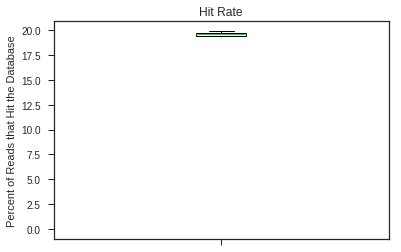

In [20]:
hit_rate
# multiple box plots on one figure
fig = plt.figure()
plt.boxplot(list(hit_rate.values()), labels=[""])
plt.ylabel("Percent of Reads that Hit the Database")
plt.title("Hit Rate")
save_plot(fig, "hit_rate")

In [21]:
def multiclass_roc(X, y, classifier=CLASSIFIER(), classes=['IGT', 'NGT', 'T2D']):
    # Binarize the output
    n_classes = len(classes)

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                        random_state=0)

    # Learn to predict each class against the other
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [22]:
def plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=2, classes=['IGT', 'NGT', 'T2D']):
    fig = plt.figure()
    lw = 2
    plt.plot(fpr[ix], tpr[ix], color=COLORS[0],
             lw=lw, label='%s ROC curve (area = %0.2f)' % (classes[ix], roc_auc[ix]), alpha=.8)
    plt.plot([0, 1], [0, 1], color=COLORS[1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if depth != 'fulldepth':
        plt.title('Receiver Operating Characteristic %s depth=.%s' % (classes[ix], str(depth)))
    else:
        plt.title('Receiver Operating Characteristic %s' % (classes[ix]))
    plt.legend(loc="lower right")
    save_plot(fig, 'roc_{}_{}'.format(depth, classes[ix]))
    
# Compute macro-average ROC curve and ROC area
def plot_multiroc_auc_classifier(depth, fpr, tpr, roc_auc, classes=['IGT', 'NGT', 'T2D']):
    lw=2
    n_classes = len(classes)
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4, alpha=.8)

    for i, color, target_name in zip(range(n_classes), COLORS, classes):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(target_name, roc_auc[i]), alpha=.8)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if depth != 'fulldepth':
        plt.title('Multiclass Receiver Operating Characteristic depth=.%s' % str(depth))
    else:
        plt.title('Multiclass Receiver Operating Characteristic')    
    plt.legend(loc="lower right")
    save_plot(fig, 'multiroc_{}'.format(depth))

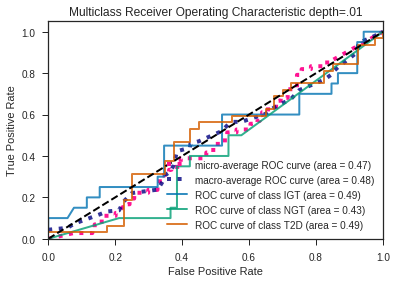

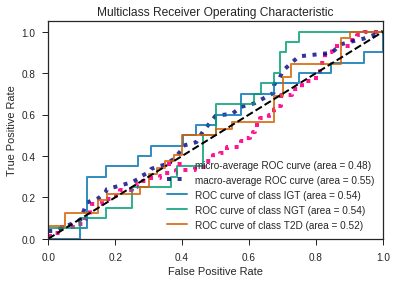

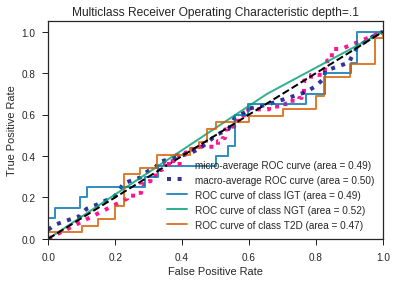

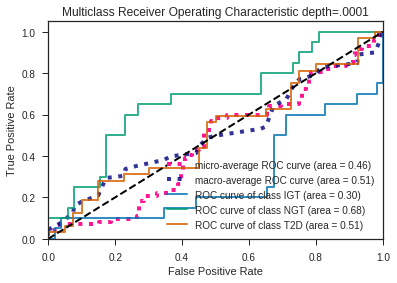

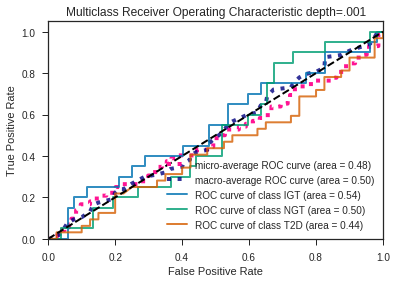

In [23]:
for depth, df in df_depths.items():
    temp_y = join_df["Classification "].values
    temp_y = label_binarize(temp_y, classes=['IGT', 'NGT', 'T2D'])
#     mask = temp_y[:, 0] == 0
#     df = df[mask]
#     temp_y = temp_y[mask]
#     temp_y = temp_y[:, 1:]
    # Make full depth classifier with 1-CV
    fpr, tpr, roc_auc = multiclass_roc(df, temp_y, classes=['IGT', 'NGT', 'T2D'])
    plot_multiroc_auc_classifier(depth, fpr, tpr, roc_auc, classes=['IGT', 'NGT', 'T2D'])
#     for i in range(3):
#         plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=i)

In [24]:
if RUN_TWO_CLASS_ROC_AUC:
    for depth, df in df_depths.items():
        temp_y = join_df["Classification "].values
        temp_y = label_binarize(temp_y, classes=['IGT', 'NGT', 'T2D'])
        mask = temp_y[:, 0] == 0
        df = df[mask]
        temp_y = temp_y[mask]
        temp_y = temp_y[:, 1:]
        # Make full depth classifier with 1-CV
        fpr, tpr, roc_auc = multiclass_roc(df, temp_y, classes=['NGT', 'T2D'])
        plot_multiroc_auc_classifier(depth, fpr, tpr, roc_auc, classes=['NGT', 'T2D'])
    #     for i in range(3):
    #         plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=i)

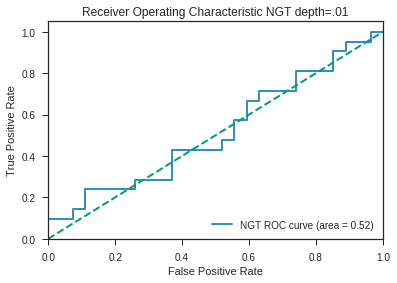

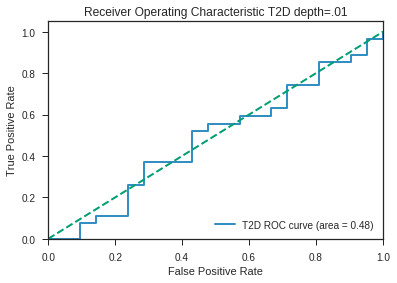

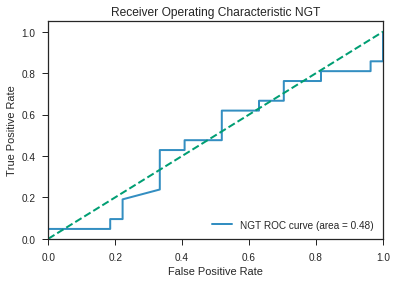

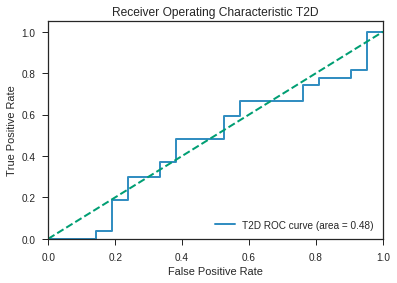

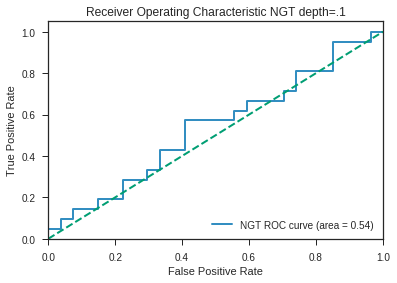

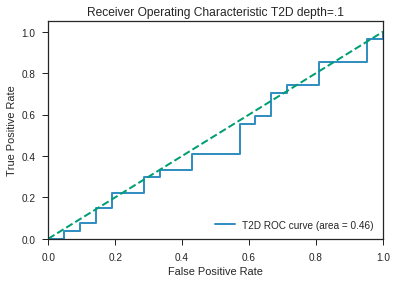

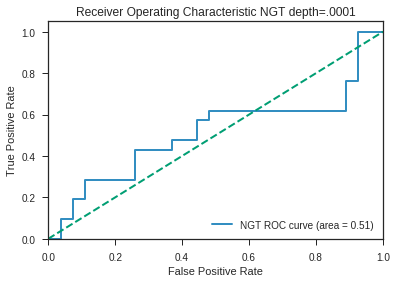

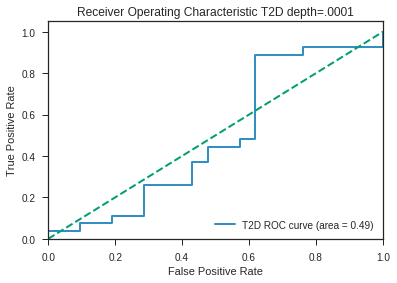

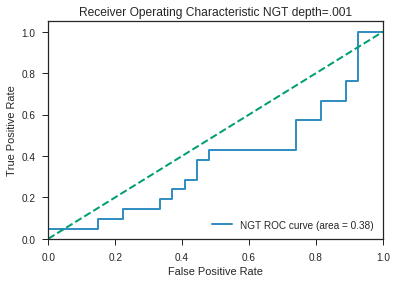

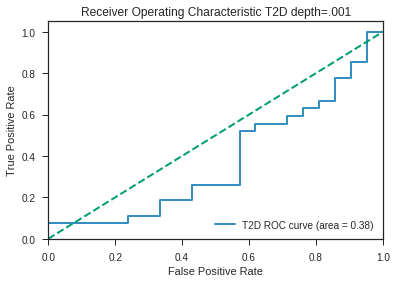

In [25]:
result_cv_scores = []
for depth, df in df_depths.items():
    temp_y = join_df["Classification "].values
    temp_y = label_binarize(temp_y, classes=['IGT', 'NGT', 'T2D'])
    mask = temp_y[:, 0] == 0
    df = df[mask]
    temp_y = temp_y[mask]
    temp_y = temp_y[:, 1:]
    # Make full depth classifier with 1-CV
    fpr, tpr, roc_auc = multiclass_roc(df, temp_y, classes=['NGT', 'T2D'])
    # Glitches at past 5
    scores = cross_val_score(CLASSIFIER(), df, temp_y, cv=5, scoring="roc_auc")
    for score in scores:
        if depth == 'fulldepth':
            depth_name = 0
        else:
            depth_name = np.log10(float("." + str(depth)))
        result_cv_scores.append([depth_name, score, TAXONOMIC_PROFILER])
    for i in range(len(CLASSES)):
        plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=i, classes=CLASSES)
df_result_cv_scores = pd.DataFrame(result_cv_scores, columns=['depth', 'score', 'profiler'])

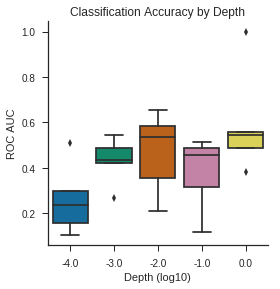

In [26]:
# df_result_cv_scores['mean'] = df_result_cv_scores.values[:,1:].mean(axis=1)
# df_result_cv_scores = df_result_cv_scores.sort_values('mean')
df_result_cv_scores.to_csv('../figures/karlsson2013_roc_cv_table.txt')
g = sns.factorplot(x="depth", y="score", kind="box", data=df_result_cv_scores, palette=COLORS, legend=False)
g.set_ylabels("ROC AUC").set_xlabels("Depth (log10)")
plt.title("Classification Accuracy by Depth")
pltname = "roc_auc"
save_plot(g, pltname)

In [27]:
def plot_pca(df_depths, y, colors=COLORS, classes=['NGT', 'T2D']):
    n_classes = len(classes)
    fulldepth_df = df_depths['fulldepth']
    pca = PCA(n_components=2)
    pca.fit(fulldepth_df)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))
    
    for depth, df in df_depths.items():
        X_r = pca.transform(df)
        fig = plt.figure()
        lw = 2
        
        
        for color, target_name in zip(colors, classes):
            plt.scatter(X_r[y == target_name, 0], X_r[y == target_name, 1], color=color, alpha=.8, lw=lw,
                        label=target_name)
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        if depth != 'fulldepth':
            plt.title('PCA of Karlsson dataset depth=.%s' % str(depth))
        else:
            plt.title('PCA of Karlsson dataset')
        save_plot(fig, 'pca_{}_nclasses{}'.format(depth, str(n_classes)))

explained variance ratio (first two components): [ 0.17425573  0.15491181]


ValueError: operands could not be broadcast together with shapes (96,316) (326,) 

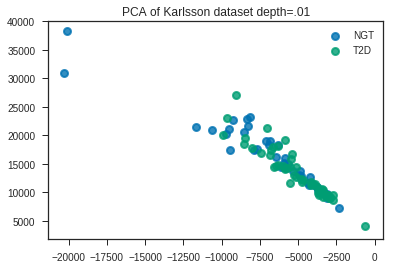

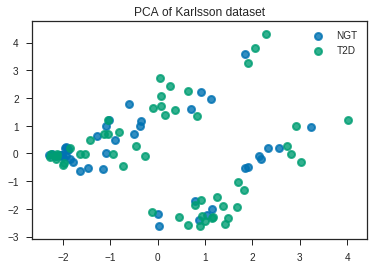

In [28]:
df_depths2 = {}
for depth, df in df_depths.items():
    temp_y = join_df["Classification "].values
    mask = temp_y != 'IGT'
    df = df[mask]
    temp_y = temp_y[mask]
    df_depths2[depth] = df  

plot_pca(df_depths2, temp_y)
plot_pca(df_depths, join_df["Classification "].values)
plot_pca(df_depths, join_df["Classification "].values, classes=['IGT', 'NGT', 'T2D'])

In [ ]:
def plot_lda(df_depths, y, colors=COLORS, classes=['NGT', 'T2D']):
    fulldepth_df = df_depths['fulldepth']
    n_classes = len(classes)
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(fulldepth_df, y).transform(fulldepth_df)
    
    lw = 2
    
    for depth, df in df_depths.items():
        X_r2 = lda.transform(df)
        fig = plt.figure()
        for color, target_name in zip(colors, classes):
            plt.scatter(X_r2[y == target_name, 0], X_r2[y == target_name, 1], alpha=.8, color=color, lw=lw, label=target_name)
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        if depth != 'fulldepth':
            plt.title('LDA of Karlsson dataset depth=.%s' % str(depth))
        else:
            plt.title('LDA of Karlsson dataset')
        save_plot(fig, 'lda_{}'.format(depth))

In [ ]:
plot_lda(df_depths, join_df["Classification "].values, classes=['IGT', 'NGT', 'T2D'])

In [ ]:
# Spearman Correlation
from scipy.stats import pearsonr

def pearson_correlations(df_depths):
    pearson_correlations = []
    fulldepth_df = df_depths['fulldepth']
    for depth, df in df_depths.items():
        if depth != 'fulldepth':
            for i, row in fulldepth_df.iterrows():
                pearson_correlations.append([np.log10(float("." + str(depth))), pearsonr(row, df.loc[i])[0], 'burst'])
    pearson_correlations.append([0, 1.0, 'burst'])
    return pd.DataFrame(pearson_correlations, columns=['depth', 'correlation', 'profiler'])

In [ ]:
pearson_df = pearson_correlations(df_depths)

In [ ]:
g = sns.factorplot(x="depth", y="correlation", hue="profiler", data=pearson_df, palette=COLORS, capsize=.2, size=6, aspect=.75, alpha=.1, legend=False)
g.set_ylabels(" Correlation").set_xlabels("Depth (log10)")
plt.title("Karlsson Pearson Correlation with Full Depth")
pltname = "pearson_correlation"
save_plot(g, pltname)

In [ ]:
# Spearman Correlation
from scipy.stats import spearmanr

def spearman_correlations(df_depths):
    spearman_correlations = []
    fulldepth_df = df_depths['fulldepth']
    for depth, df in df_depths.items():
        if depth != 'fulldepth':
            for i, row in fulldepth_df.iterrows():
                spearman_correlations.append([np.log10(float("." + str(depth))), spearmanr(row, df.loc[i])[0], 'burst'])
    spearman_correlations.append([0, 1.0, 'burst'])
    return pd.DataFrame(spearman_correlations, columns=['depth', 'correlation', 'profiler'])

In [ ]:
spearman_df = spearman_correlations(df_depths)
g = sns.factorplot(x="depth", y="correlation", hue="profiler", data=spearman_df, palette=COLORS, capsize=.2, size=6, aspect=.75, alpha=.1, legend=False)
g.set_ylabels("Spearman Correlation").set_xlabels("Depth (log10)")
plt.title("Spearman Correlation with Full Depth")
pltname = "spearman_correlation"
save_plot(g, pltname)

In [ ]:
from skbio.stats.composition import ancom, clr_inv

results = []
for depth, df in df_depths.items():
    if CLR:
        data = clr_inv(df)
        df = pd.DataFrame(data, index=df.index, columns=df.columns)
    results.append([depth, ancom(df, join_df["Classification "])])
    

In [ ]:
g = sns.factorplot(x="depth", y="correlation", hue="profiler", data=df_dice, palette=COLORS, capsize=.2, size=6, aspect=.75, alpha=.1, legend=False)
g.set_ylabels("Dice Coefficients").set_xlabels("Depth (log10)")
plt.title("Dice Coefficients with Full Depth")
pltname = "dice_coefficients"
save_plot(g, pltname)

In [ ]:
for result in results:
    print(result[1][0]['Reject null hypothesis'].sum())